# Recognising NRs


In [33]:
import sys
import os

wdirs = ["/mnt/data/Anastasia/Glass","/mnt/data/Anastasia/18_11_29_pd23_11_div6_25Hzsqwave/",
"/mnt/data/Anastasia/QDs_prelabsem1811/","/mnt/data/Anastasia/Initial/",
"/mnt/data/Anastasia/test_18_07_11_pd29_06_div12_WISSNR/"]

dfiles = []
for dirt in wdirs:
    basedir = dirt
    files = os.listdir(basedir)
    if dirt[-1] != '/':
        dirt = dirt+'/'
    for f in files:
        if f[-4:]=='.tif': 
            try:
                i = int(f[-5])
                dfiles.append(dirt+f)
            except:
                pass
cfile = dfiles[0]
wdir = ''
cf2 = cfile.split(".")[0].split("/")
for fs in cf2[:-1]:
    wdir = wdir+fs+'/'
wdir = wdir+cf2[-1]+'output/sptrack/'


In [34]:
cfile

'/mnt/data/Anastasia/Glass/field1_2.tif'

In [126]:
sys.path.append("/export/home1/users/bssn/serna/GitIBENS/Nanorods")

In [35]:
from numpy import *
from matplotlib.pylab import *
import scipy.optimize as opt
import pickle
from scipy.optimize import minimize,least_squares
from scipy.stats import linregress

%matplotlib inline

In [129]:
from signal_analysis.core import dblgausfit,dblgaussd

In [36]:
with open(wdir+'data_msd.pickle', 'rb') as handle:
    data = pickle.load(handle)


In [37]:
def bimod(x):
    m1 = mean(x)
    m2 = std(x)
    m3 = mean((x-m1)**3)/m2**3
    m4 = mean((x-m1)**4)/m2**4
    return((m3**2+1)/m4)

In [137]:
driftcorrected = True
dirt = wdir
basedir = dirt
files = os.listdir(basedir)

dfiles = []

if driftcorrected:
    for f in files:
        if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]=='DC': dfiles.append(basedir+f)
else:
    for f in files:
        if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]!='DC': dfiles.append(basedir+f)
    
dfiles.sort()

dgps = []
idx0 = []
amps = []
for ni,name in enumerate(dfiles):
    popts = load(name)
    posx = popts[:,5]
    posy = popts[:,6]
    amp = popts[:,0]
    th = 0
    th2 = 13.0
    sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    Tf = len(posx)
    if sel.sum() > 1000:
        amps.append([mean(amp[sel]),mean(popts[sel,4]),bimod(amp[sel])])
        idx0.append(ni)
        
        m1,m2 = (mean(amp[sel]),std(amp[sel]))
        am = (amp[sel]-m1)/m2
        h = histogram(am,arange(min(am),max(am),0.2))
        hd = h[0]/sum(h[0])/0.2
        hx = (h[1][1:]+h[1][:-1])/2.0
        dgfit = dblgausfit(hx,hd,par0=array([0.5,-1,.5,1,.5]))
        dgps.append(concatenate(([m1,m2],dgfit.x)))
        #if ni<15:
        #    plot(hx,hd,'.')
        #    plot(linspace(-4,4,100),dblgaussd(linspace(-4,4,100),dgfit.x))
        #else:
        #    break
dgps = array(dgps)
ampst = array(amps)
idx0 = array(idx0)


In [139]:
dgps.shape

(3253, 7)

(3238,)


Text(0,0.5,'p_1')

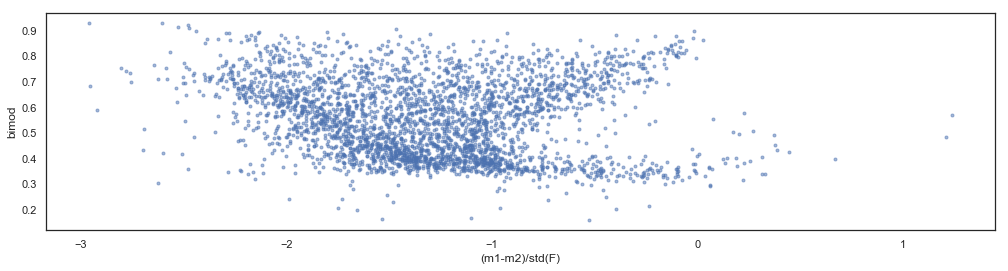

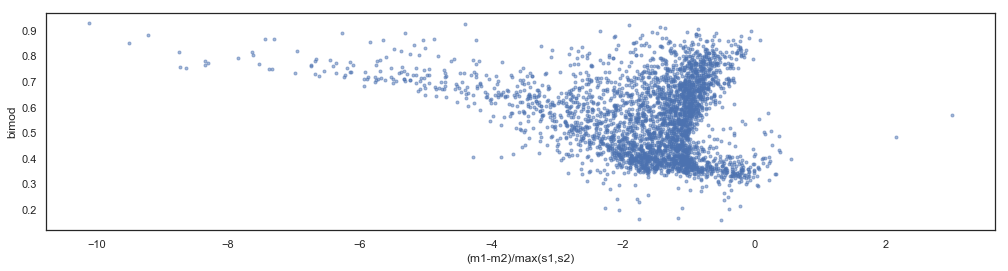

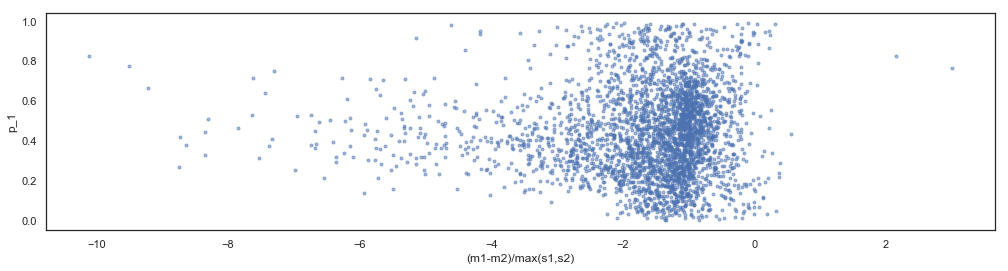

In [154]:
sel = (abs(dgps[:,3]-dgps[:,5])<3)*(dgps[:,2]>0)*(dgps[:,2]<1)
figure(figsize=(17,4))
plot(dgps[sel,3]-dgps[sel,5],ampst[sel,2],'.',alpha=0.5)
xlabel("(m1-m2)/std(F)")
ylabel("bimod")
figure(figsize=(17,4))
s1 = column_stack((dgps[sel,6],dgps[sel,4])).max(axis=1)
#s1 = column_stack((dgps[sel,6],dgps[sel,4])).sum(axis=1)

print(s1.shape)
plot((dgps[sel,3]-dgps[sel,5])/s1,ampst[sel,2],'.',alpha=0.5)
xlabel("(m1-m2)/max(s1,s2)")
ylabel("bimod")
figure(figsize=(17,4))
plot((dgps[sel,3]-dgps[sel,5])/s1,dgps[sel,2],'.',alpha=0.5)
xlabel("(m1-m2)/max(s1,s2)")
ylabel("p_1")

In [6]:
def conditionnumber(a,D):
    if a<0.1:
        return(0)
    if a>0.1 and a<0.4:
        return(1)
    if a>0.4 and a<1.0 and D<1e-2:
        return(2)
    if a>1.0 and a<3.0 and D>1e-2:
        return(3)
    if a>1.0 and a<3.0 and D<1e-2:
        return(4)
    if a>3.0:
        return(5)
    return(6)
    
def conditionlabel(i):
    if i==0:
        return("Amp/Bg<0.1")
    if i==1:
        return("0.1< Amp/Bg <0.4")
    if i==2:
        return("0.4< Amp/Bg <1.0 & D0<0.01 um2/s")
    if i==3:
        return("1< Amp/Bg <3 & D0>0.01 um2/s")
    if i==4:
        return("1< Amp/Bg <3 & D0<0.01 um2/s")
    if i==5:
        return("Amp/Bg>3")
    if i==6:
        return("Others")

#sel = (ampst[:,0]/ampst[:,1]>0.1)*(ampst[:,0]/ampst[:,1]<0.4)
#sel = (ampst[:,0]/ampst[:,1]>0.4)*(ampst[:,0]/ampst[:,1]<1.0)*(Des[:,0]<1e-2)
#sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]>1e-2)
#sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]<1e-2)
#sel0 = (ampst[:,0]/ampst[:,1]>3.0)
#conditionnumber(0.5,0.6)

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


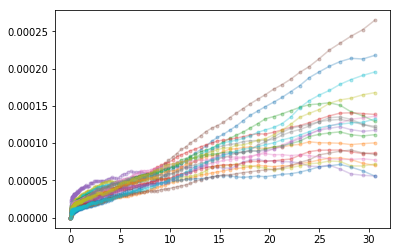

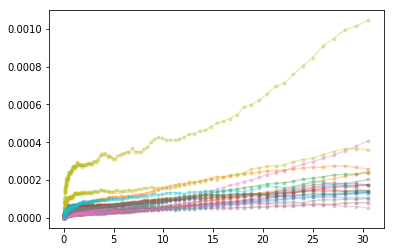

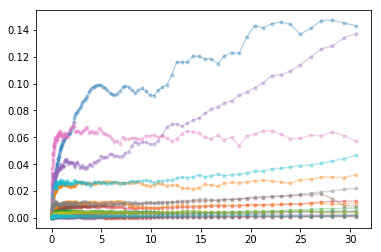

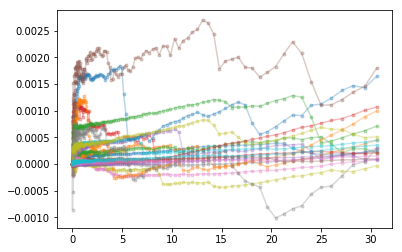

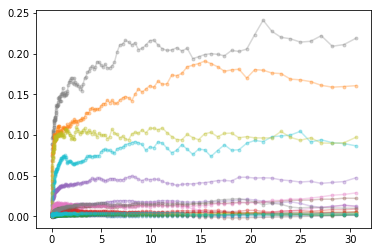

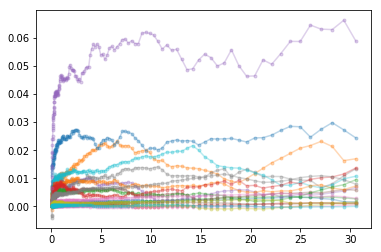

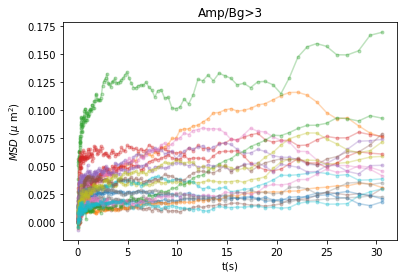

In [7]:
tmax = data[0][1].shape[0]

t = arange(tmax)


for ic in range(6):
    figure(ic)
    title(conditionlabel(ic))

cmapt = get_cmap('tab20')

counter = zeros(7)
k = 0
for i in range(len(data)):
    d = data[i]
    ni,yt,ey2,cnt = d
   
    xtt = t*10.0e-3
    ytt = yt*.325**2
    
    dto =  log(tmax)/200
    tml = log(t[1:])
    ntl = int(tml[-1]/dto)+1
    t0l = 0
    dd = zeros((ntl,2))-1
    dd[0,:2] = (t[1],ytt[1])
    for il in arange(1,ntl):
        til = t0l+dto
        sel = (tml>=t0l)*(tml<til)
        if sel.sum()>0:
            xe = xtt[1:][sel]
            ye = ytt[1:][sel]
            dd[il,:2] = [mean(xe),mean(ye)]
        t0l = til

    dde = dd[dd[:,0]>0,:]
    dde = dde[1:,:]
    
    if i == 0:
        xde = column_stack((dde,dde[:,:1]*0+i))
        xden = column_stack((dde[:,:1],(dde[:,1:2]-dde[0,1])/(dde[-1,1]-dde[0,1]),dde[:,:1]*0+i))
    else:
        xde = row_stack((xde,column_stack((dde,dde[:,:1]*0+i))))
        xden = row_stack((xden,column_stack((dde[:,:1],(dde[:,1:2]-dde[0,1])/(dde[-1,1]-dde[0,1]),dde[:,:1]*0+i))))
        
    ntle = dde.shape[0]
    nwin = 50
    ds = zeros((ntle+nwin-3,3))
    for il in range(ntle+nwin-3):
        sel = arange(il-nwin+3,il+3)
        sel = sel[(sel>=0)*(sel<ntle)]
        xe = dde[sel,0]
        ye = dde[sel,1]    
        lm = linregress(xe,ye)
        ds[il,0] = mean(xe)    
        ds[il,1:3] = (lm.slope,lm.stderr)    
    
    #print(i)
    
    xt = ds
    xt = xt[xt[:,1]>0,:]
    De = array([mean(xt[xt[:,0]<1e-1,1]),exp(mean(log(xt[xt[:,0]<1e-1,1])))])

    ic = conditionnumber(ampst[i,0]/ampst[i,1],De[0])
    if counter[ic]< 20:
        figure(ic)
        plot(dde[:,0],dde[:,1]-dde[0,1],'.-',alpha=0.3,label=i)
        counter[ic] +=1

    if i == 0:
        xds = column_stack((ds,ds[:,:1]*0+i))
    else:
        xds = row_stack((xds,column_stack((ds,ds[:,:1]*0+i))))
        
xds = array(xds)
xde = array(xde)
xden = array(xden)

#yscale("log")
#xscale("log")

for ic in range(6):
    figure(ic)
    xlabel("t(s)")
    ylabel("$MSD$ ($\mu$ m$^2$)")



In [52]:

ts = array([100,200,400,800,1600,3200,6400,12800])/1000.0
xt = xde[abs(xde[:,-1]-i)<1e-3,0]
idxts = zeros(ts.shape[0],dtype=int)
idx = arange(xt.shape[0])
for i in range(len(ts)):
    idxts[i] = idx[argmin(abs(xt-ts[i]))]

alphas = zeros((len(data),7))
alphalm = zeros((len(data),2))

Des = zeros((len(data),3))
Dep = zeros((len(data),6))

for i in range(len(data)):
    xt = xds[abs(xds[:,-1]-i)<1e-3,:]
    xt = xt[xt[:,1]>0,:]
    try:
        De = array([mean(xt[xt[:,0]<2e-1,1]),mean(xt[xt[:,0]<2e-1,2]),max(xt[xt[:,0]<2e-1,2])])
        sel = (xt[:,0]>2e-1)*(xt[:,0]<1.5e0)
        De2 = array([mean(xt[sel,1]),mean(xt[sel,2]),max(xt[sel,2])])
        sel = (xt[:,0]>1.5e0)*(xt[:,0]<1.5e1)
        De3 = array([mean(xt[sel,1]),mean(xt[sel,2]),max(xt[sel,2])])

        xt = xde[abs(xde[:,-1]-i)<1e-3,:]    
        msds = xt[idxts,:]
        msds = msds[1:,:]/msds[:-1,:]
        alpha = log(msds[:,1])/log(msds[:,0])
        lm = linregress(log(msds[:,0]).cumsum(),alpha)
        alphas[i,:] = alpha
        alphalm[i,:] = (lm.slope,lm.intercept)
        Des[i,:] = De
        Dep[i,:] = concatenate((De2,De3))
    except:
        pass

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
import seaborn as sns
sns.set(style="white", color_codes=True)

In [42]:
De.shape

(3,)

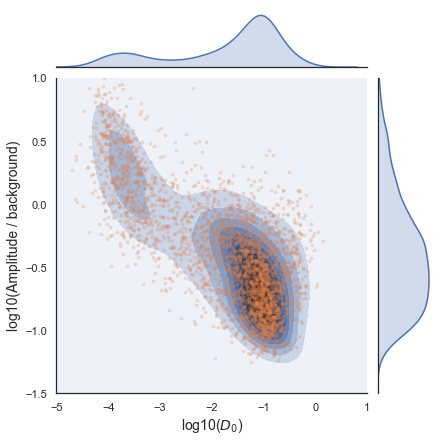

In [43]:
yt = ampst[:,0]/ampst[:,1]
xt = Des[:,0]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

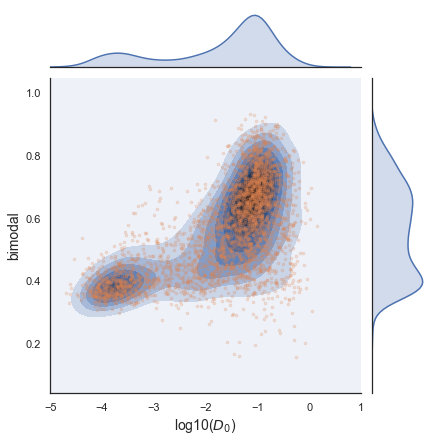

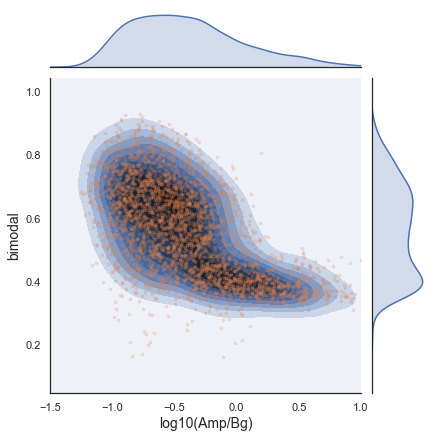

In [44]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

#g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

yt = ampst[:,2]
xt = ampst[:,0]/ampst[:,1]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-1.5,1.0])
#g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10(Amp/Bg)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

<Figure size 432x288 with 0 Axes>

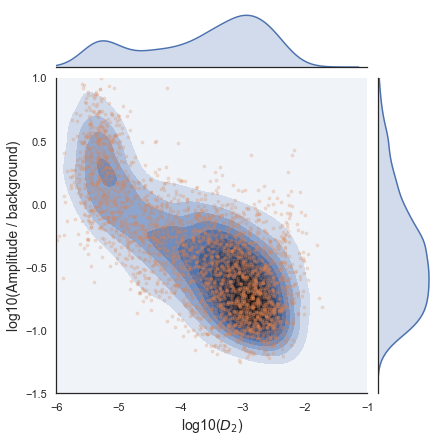

In [45]:
yt = ampst[:,0]/ampst[:,1]
xt = Dep[:,3]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
fig = figure()
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-6,-1])
g.ax_joint.set_xlabel("log10($D_2$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

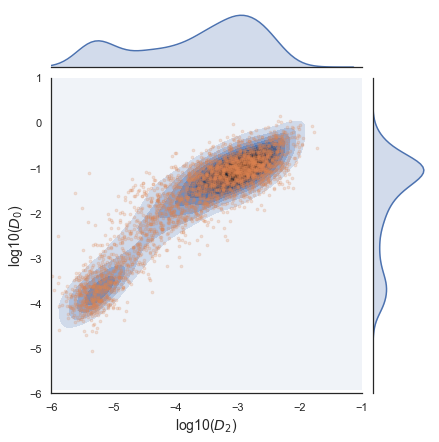

In [46]:
yt = Des[:,0]
xt = Dep[:,3]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-6,1.0])
g.ax_joint.set_xlim([-6,-1])
g.ax_joint.set_xlabel("log10($D_2$)",fontsize=14)
g.ax_joint.set_ylabel("log10($D_0$)",fontsize=14)
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

In [47]:
yt = 1.0*ampst[:,0]/ampst[:,1]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = log10(yt[sel])


NRs selected:  [3246 1584 1652]


Text(0.5,0,'t')

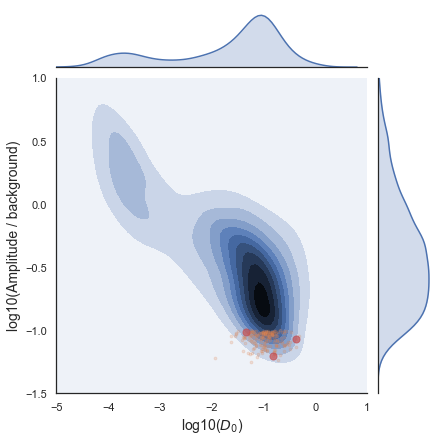

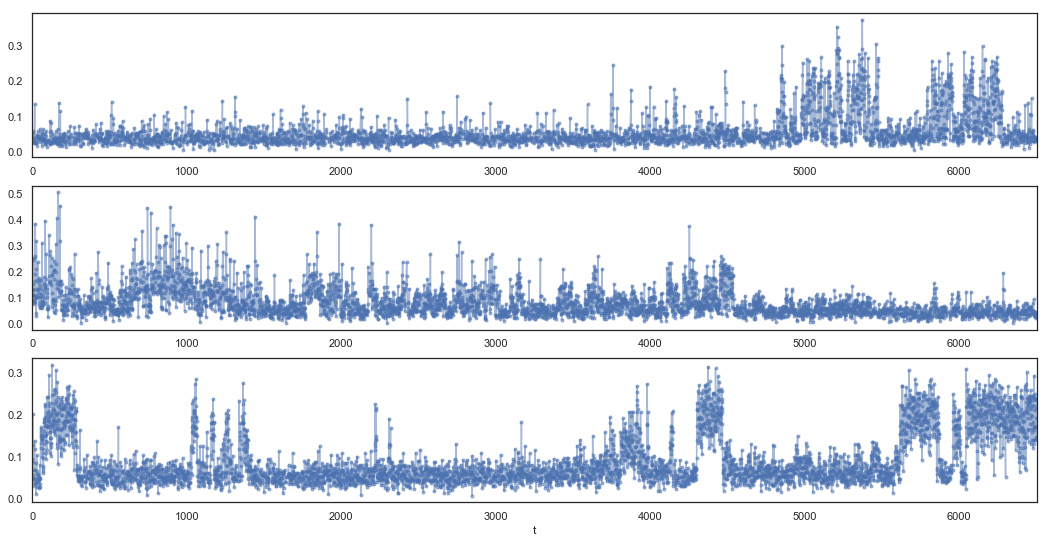

In [58]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = ampst[:,0]/ampst[:,1]<0.1

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)


it = permutation(arange(ampst.shape[0])[sel])[:3]
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)
print('NRs selected: ' ,it)

#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
#fig.title("Amplitude/Background < 0.1")
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [57]:
sel = ampst[:,0]/ampst[:,1]<0.1
it = permutation(arange(len(xt))[sel])[:3]
print(it,idx0[it])

[1730 1655 3205] [1732 1657 3207]


NRs selected:  [1148 3088 3052]


Text(0.5,0,'t')

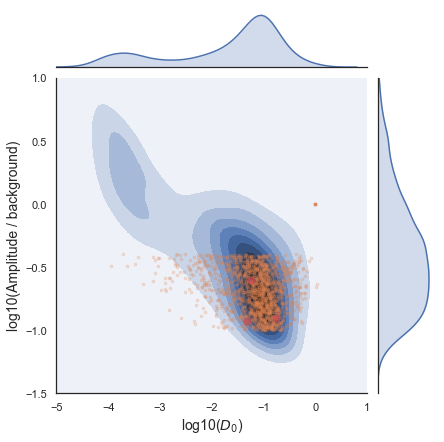

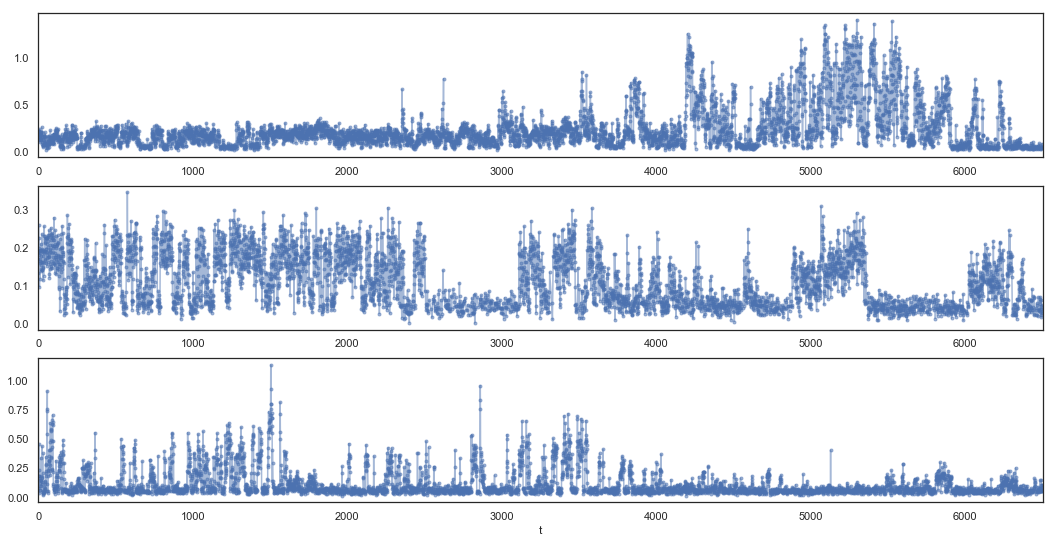

In [59]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>0.1)*(ampst[:,0]/ampst[:,1]<0.4)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)

print('NRs selected: ' ,it)
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [329 305 318]


Text(0.5,0,'t')

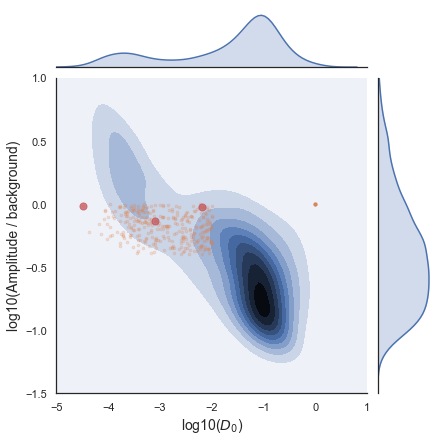

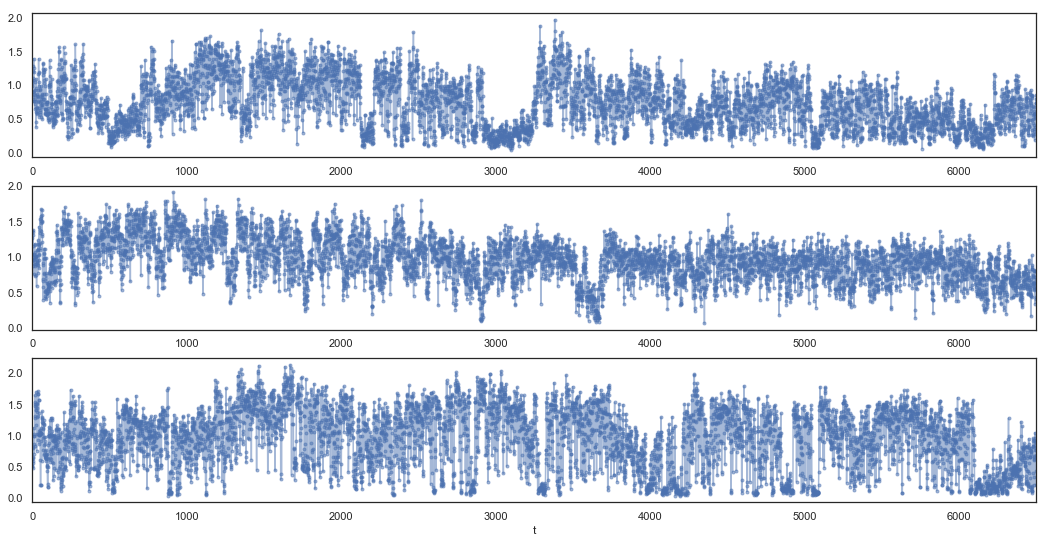

In [60]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>0.4)*(ampst[:,0]/ampst[:,1]<1.0)*(Des[:,0]<1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)
it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)

fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [2094  206  194]


Text(0.5,0,'t')

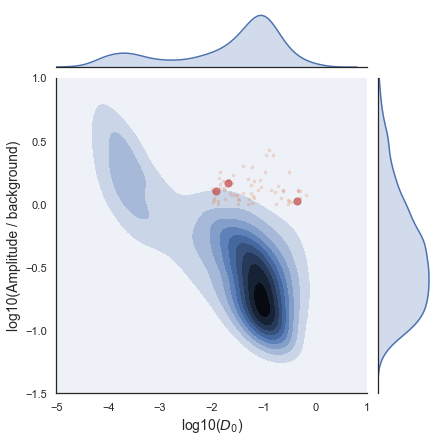

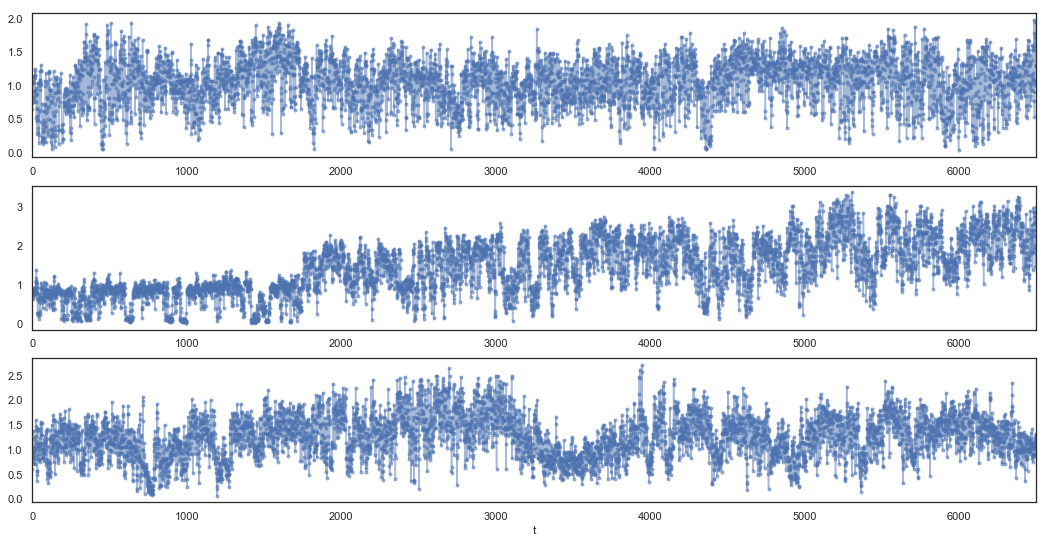

In [61]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]>1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)
it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [ 281 1868 1927]


Text(0.5,0,'t')

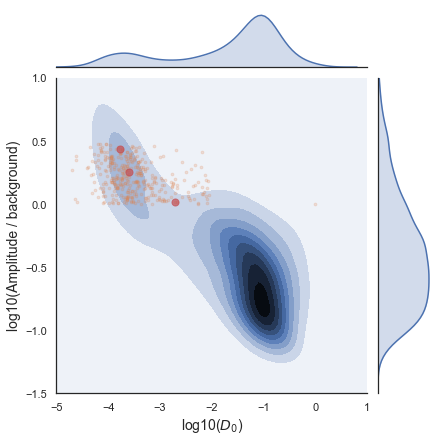

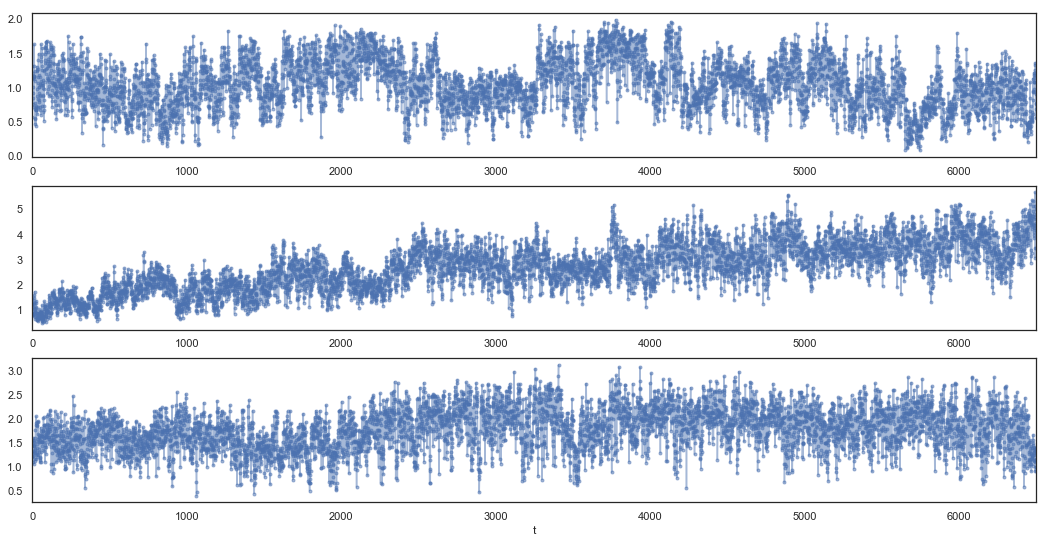

In [62]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]<1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
#fig = figure(figsize=(14,8))
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
print('NRs selected: ' ,it)
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [33]:
print(log10(ampst[254,0]/ampst[254,1]),log10(Des[254,0]))

0.07353855473459661 -2.056994987766364


NRs selected:  [1807 1874 1850]


Text(0.5,0,'t')

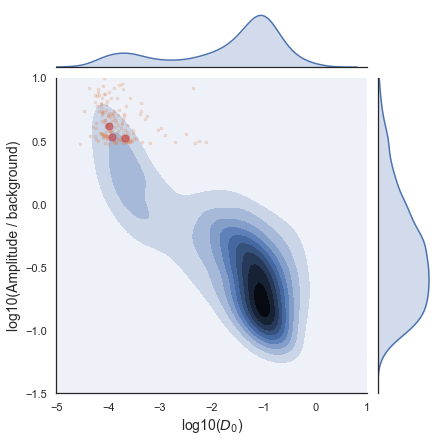

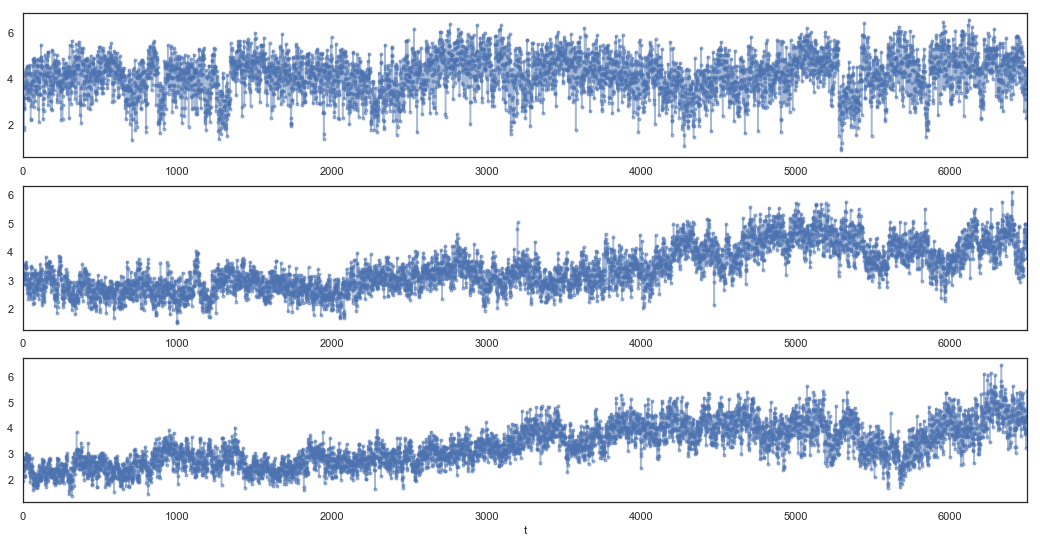

In [63]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>3.0)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [64]:
yt = 1.0*ampst[:,2]
xt = ampst[:,0]/ampst[:,1]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])

NRs selected:  [2120  453 2267]


Text(0.5,0,'t')

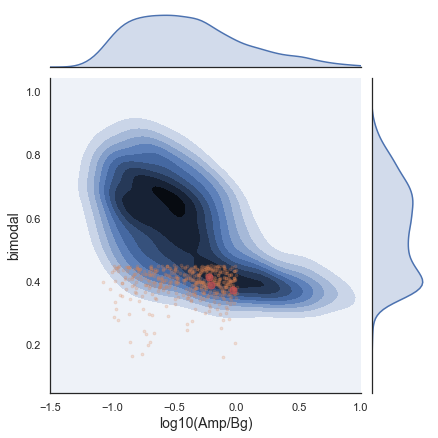

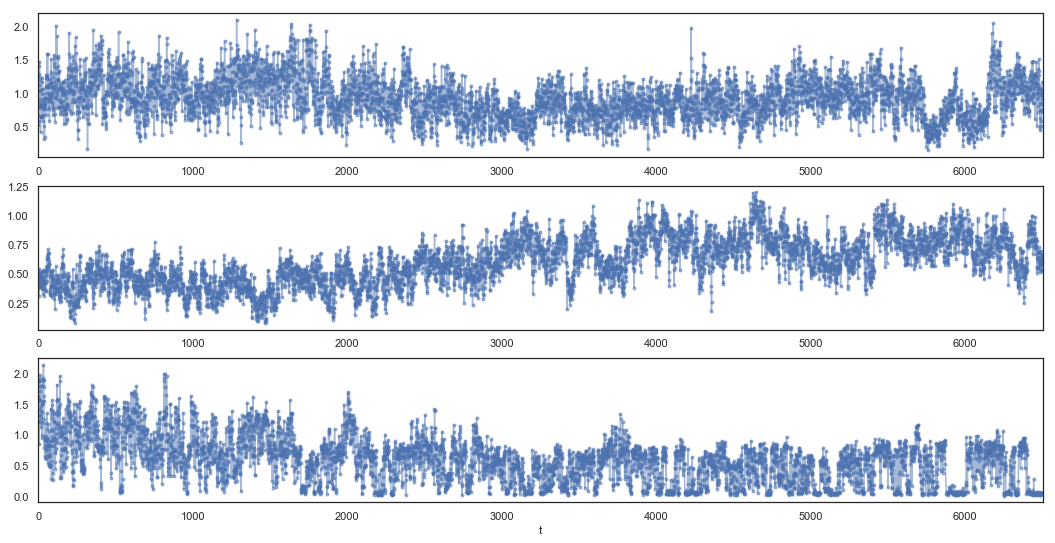

In [65]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-1.5,1.0])
g.ax_joint.set_xlabel("log10(Amp/Bg)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]<0.45)*(ampst[:,0]/ampst[:,1]<1.0)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [92]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])

In [93]:
%matplotlib inline

NRs selected:  [1849  251 2071]


Text(0.5,0,'t')

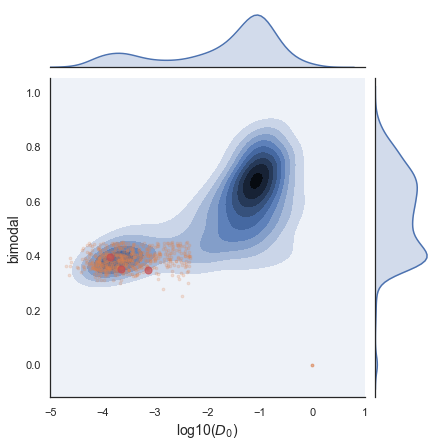

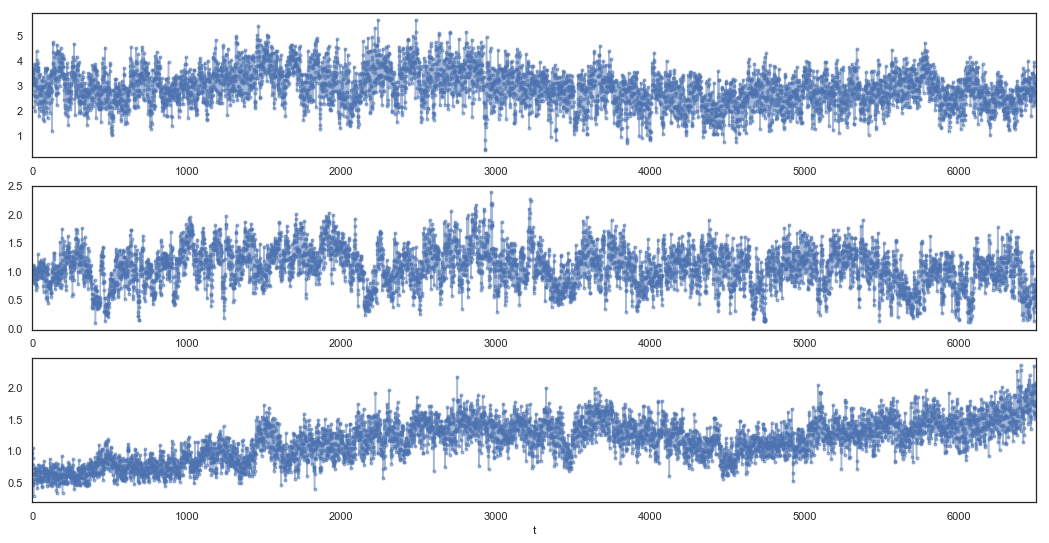

In [94]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]<0.45)*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [73]:
ampst[2317,2]

0.3867750684249367

(array([1.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 1.200e+01, 3.700e+01,
        6.200e+01, 9.200e+01, 1.220e+02, 1.530e+02, 1.450e+02, 1.290e+02,
        1.290e+02, 1.310e+02, 1.070e+02, 1.040e+02, 9.600e+01, 1.080e+02,
        9.400e+01, 1.120e+02, 1.120e+02, 1.180e+02, 1.030e+02, 1.050e+02,
        1.080e+02, 1.680e+02, 2.670e+02, 5.540e+02, 1.415e+03, 1.280e+03,
        2.310e+02]),
 array([1.90205459, 2.03905247, 2.17605036, 2.31304824, 2.45004612,
        2.587044  , 2.72404188, 2.86103976, 2.99803765, 3.13503553,
        3.27203341, 3.40903129, 3.54602917, 3.68302706, 3.82002494,
        3.95702282, 4.0940207 , 4.23101858, 4.36801647, 4.50501435,
        4.64201223, 4.77901011, 4.91600799, 5.05300588, 5.19000376,
        5.32700164, 5.46399952, 5.6009974 , 5.73799529, 5.87499317,
        6.01199105, 6.14898893]),
 <a list of 31 Patch objects>)

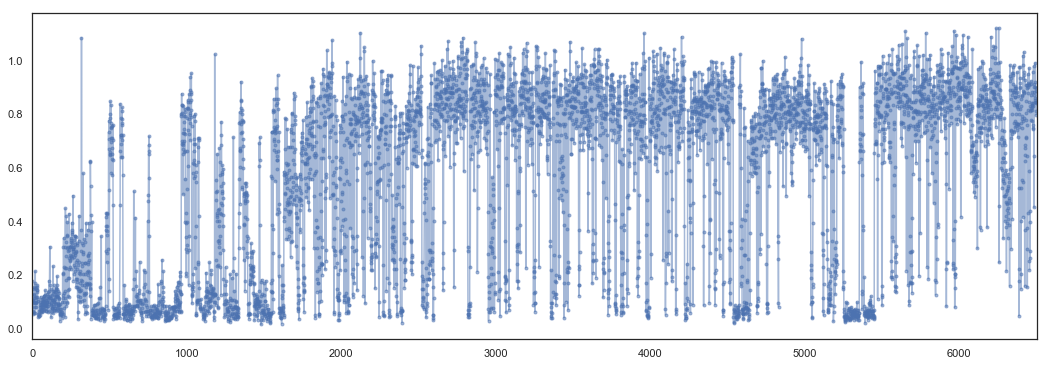

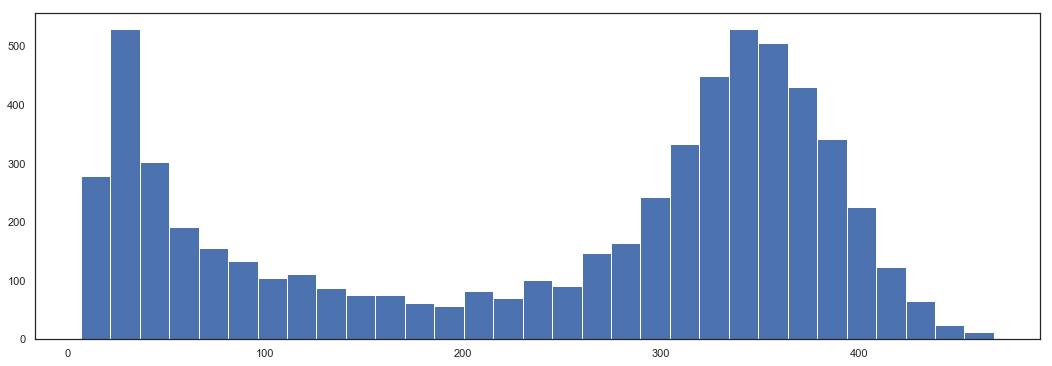

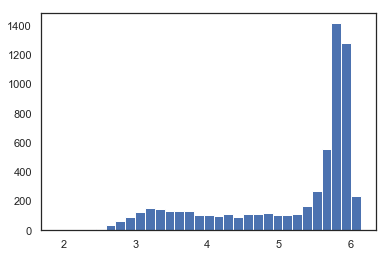

In [119]:
figure(figsize=(18,6))
i = 2317
name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
xlim(0,6500)
figure(figsize=(18,6))
hist(amp[sel],31)
figure()
hist(log(amp[sel]),31)

In [77]:
bimod(amp[sel])

0.7513394568426739

In [98]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])

In [99]:
%matplotlib inline

NRs selected:  [ 491 2297 2617]


Text(0.5,0,'t')

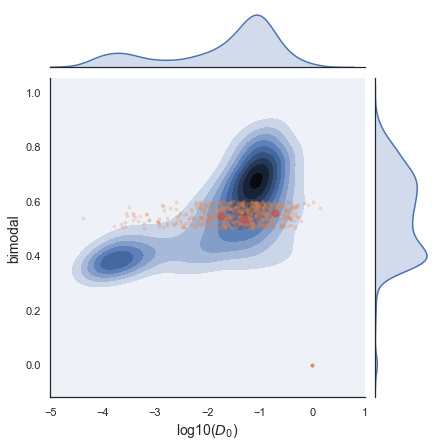

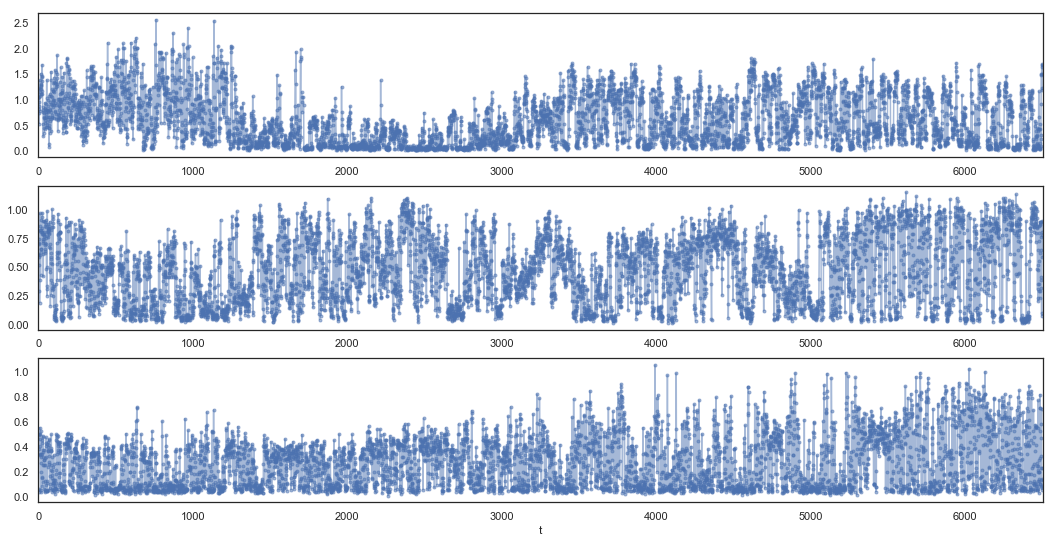

In [117]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [155]:
%matplotlib inline

NRs selected:  [3133 3204 2408]


Text(0.5,0,'t')

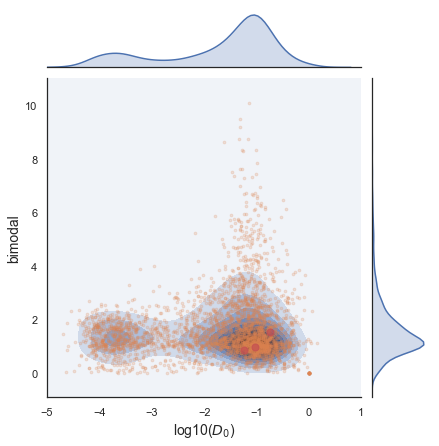

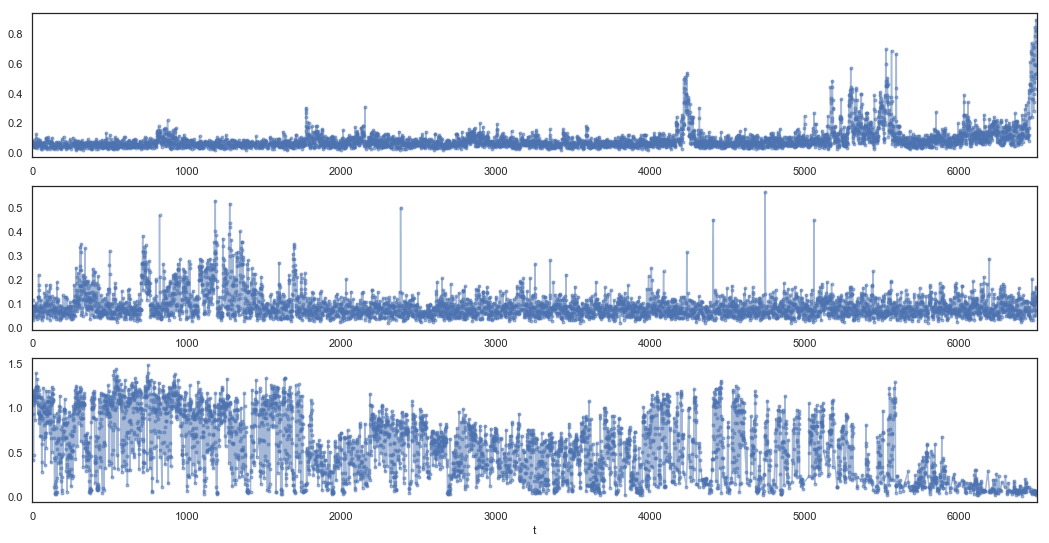

In [158]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = isfinite(ampst[:,2])#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [ 814  997 2314]


Text(0.5,0,'t')

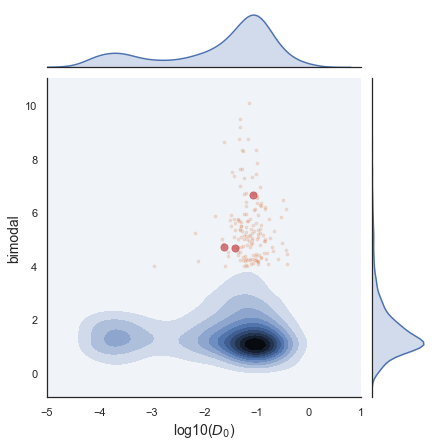

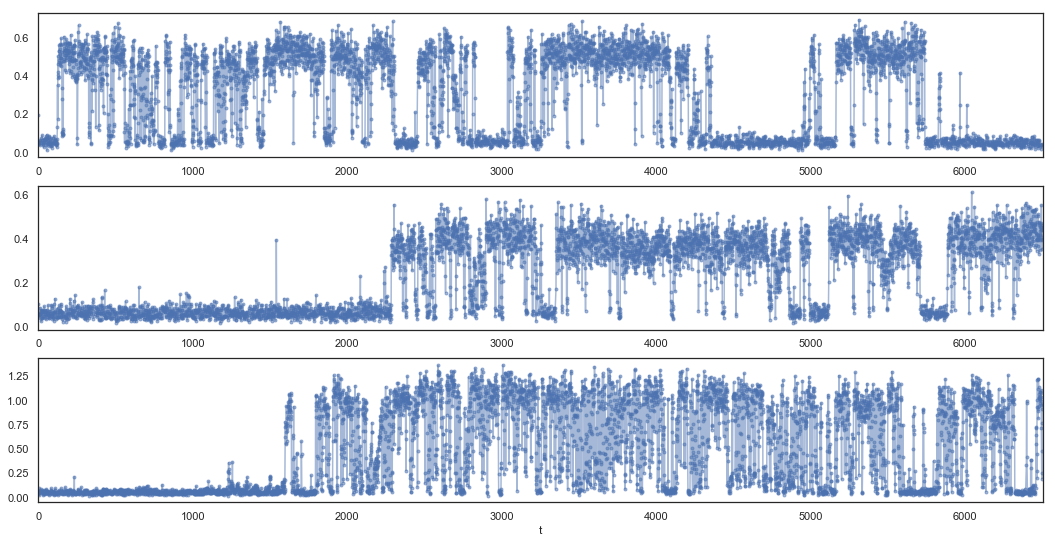

In [178]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = yt>4#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [ 899 2384 1229]


Text(0.5,0,'t')

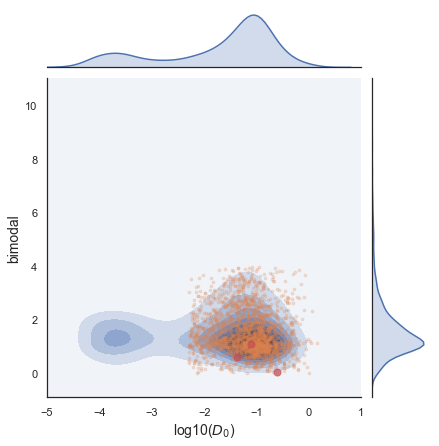

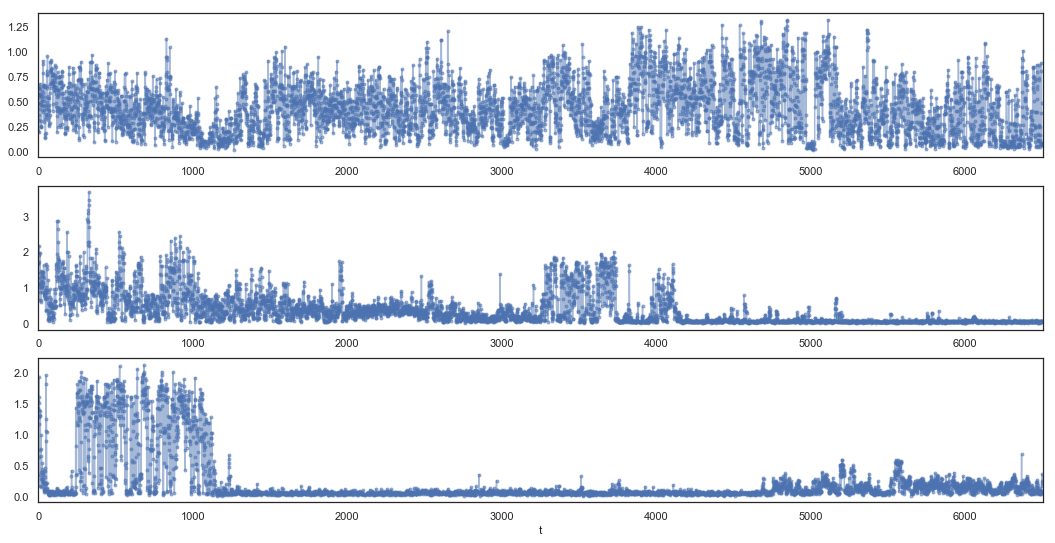

In [177]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (yt<4)*(Des[:,0]>.50e-2)#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [ 179  541 1833]


Text(0.5,0,'t')

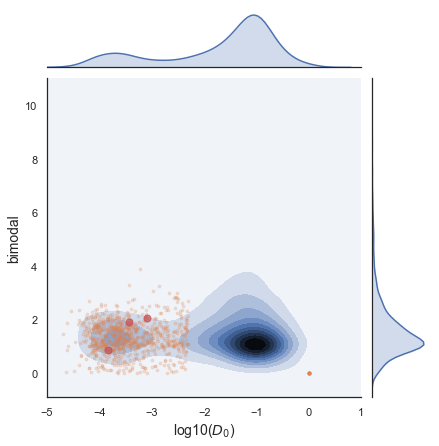

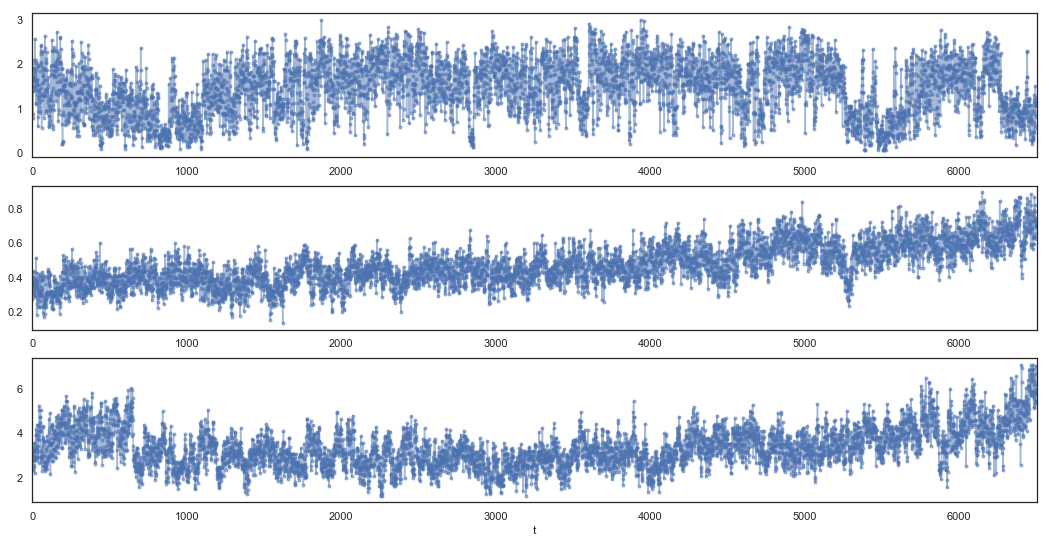

In [176]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (yt<4)*(Des[:,0]<.50e-2)#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [114]:
log10(Des[847,2])

-0.6103301839728541

In [69]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


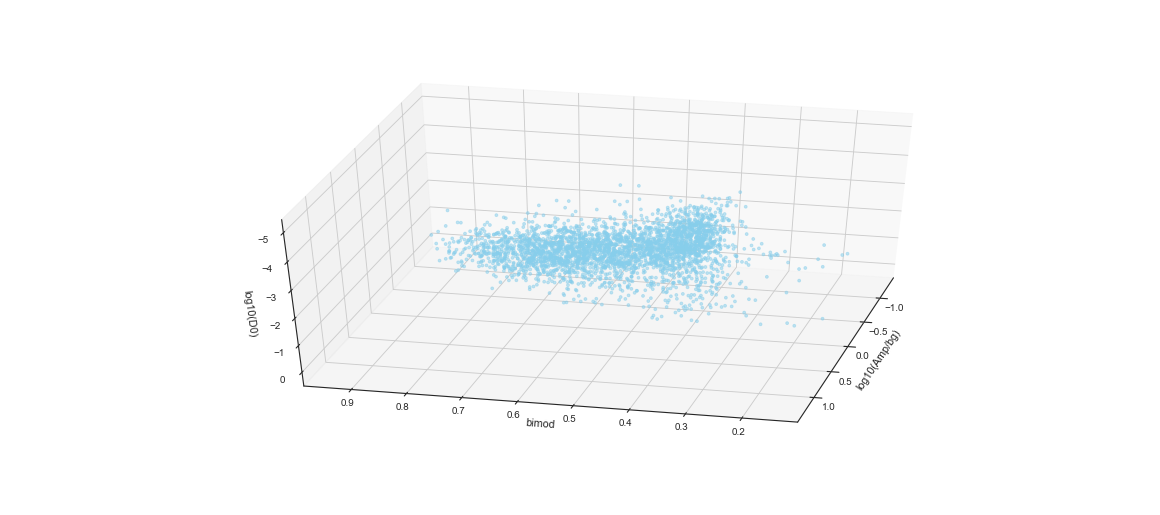

Text(0.5,0,'log10(D0)')

In [97]:
%matplotlib notebook
%matplotlib notebook
yt = 1.0*ampst[:,2]
zt = 1.0*Des[:,0]
xt = ampst[:,0]/ampst[:,1]
sel = (xt>0)*(yt>0)*(zt>0)
xt = log10(xt[sel])
zt = log10(zt[sel])
yt = yt[sel] #log10(yt[sel])

fig = figure(1,figsize=(18,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xt, yt, zt, c='skyblue', s=10,alpha=0.5)
#ax.view_init(30, 185)
ax.set_xlabel("log10(Amp/bg)")

ax.set_ylabel("bimod")

ax.set_zlabel("log10(D0)")

In [173]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
zt = 1.0*ampst[:,2]
at = ampst[:,0]/ampst[:,1]
at2 = (dgps[:,0]+dgps[:,1]*column_stack((dgps[:,3],dgps[:,5])).max(axis=1))/ampst[:,1]
xt = 1.0*Des[:,0]
xt2 = Dep[:,0]
xt3 = Dep[:,3]
sel = (xt>0)*(xt2>0)*(xt3>0)*(zt>0)*(abs(yt)<20)
xt = log10(xt[sel])
xt2 = log10(xt2[sel])
xt3 = log10(xt3[sel])
yt = yt[sel] #log10(yt[sel])
zt = zt[sel]
at = log10(at[sel])
at2 = log10(at2[sel])
#  (m1-m2)/max(s1,s2), bimod, A/bg, A_on/bg, D0, D1, D2
data = column_stack((yt,zt,at,at2,xt,xt2,xt3))
savetxt('stats_0.dat',data,header='#  (m1-m2)/max(s1,s2), bimod, A/bg, A_on/bg, D0, D1, D2')

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


In [168]:
column_stack